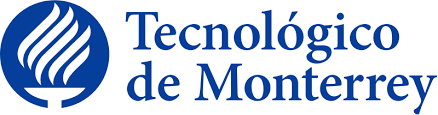

#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Procesamiento de Lenguaje Natural (NLP)**
###Tecnológico de Monterrey
###Prof Luis Eduardo Falcón Morales

## **Actividad en Equipos - Semana 10: Transformer GPT & Web-Scraping**

###**Equipo 5:**

###**A01748750 - Evelyn Aylin Rendón Medina**
###**A01002111 - Luis Salvador Cruz Najera**
###**A01169213 - Laura Elena Hernández Mata**
###**A01793052 - Juan Carlos Lopez Cruz**
###**A01793054 - Rafael José Mateo Comprés**


#**Actividad en Equipos - Semana 10:**

En la actividad de esta semana trabajarás en equipos mediante el uso del Transformer GPT y comentarios de usuarios obtenidos mediante WebScraping en Tripadvisor.

A través de Tripadvisor ( https://www.tripadvisor.es/ ) en español obtendremos los comentarios de usuarios sobre su experiencia en un hotel en particular. En esta plataforma se evalúa la experiencia mediante puntos de 1 a 5, que corresponden de manera ascendente a “Pésimo”, “Malo”, “Normal”,“Muy bueno” y “Excelente”.

Una de las formas en que se han venido utilizando los generadores de texto como el GPT, es para generar datos sintéticos de texto que no tengan problemas de privacidad. En particular en esta actividad los usaremos para generar datos sintéticos sobre comentarios positivos y negativos de usuarios y posteriormente los usaremos para ver si ayudan a mejor el desempeño de un modelo de clasificación.

De la siguiente liga de Tripadvisor selecciona un hotel en la zona de la ciudad de Monterrey, México, que consideres adecuado para extraer los comentarios de español y evaluaciones de usuarios:

https://www.tripadvisor.es/Hotels-g150782-Monterrey_Northern_Mexico-Hotels.html

En particular trata de seleccionar algún hotel cuyas calificaciones consideres desbalanceadas, al verlo como un problema binario: Positivo (4, 5) y Negativo (1, 2 3).

### **Librerías que se deben Instalar.**

In [ ]:
!pip install transformers==4.28.0 datasets evaluate pysentimiento sentencepiece sacremoses accelerate
!apt-get install git-lfs
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 36.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 26.0 MB/s eta 0:

### **Librerías a Utilizar.**

In [ ]:
import requests
from bs4 import BeautifulSoup as soup
from random import randint
from time import sleep
import re
from datasets import Dataset, load_dataset, DatasetDict
import evaluate
from evaluate import evaluator
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer, pipeline
from transformers import AutoConfig
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import csv
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# **Actividades:**

##1.- Mediante web scraping realiza una extracción de los comentarios y calificaciones a dicho hotel. Recuerda que Tripadvisor representa las calificaciones mediante círculos verdes. Los comentarios deben ser de usuarios que los redactaron en idioma en español. Indica la cantidad de comentarios y sus calificaciones que extrajiste.##

In [ ]:
#url = 'https://www.tripadvisor.es/Hotel_Review-g150782-d9137890-Reviews-Fiesta_Americana_Monterrey_Pabellon_M-Monterrey_Northern_Mexico.html'
url = 'https://www.tripadvisor.es/Hotel_Review-g150782-d155753-Reviews-Krystal_Monterrey-Monterrey_Northern_Mexico.html'
html = requests.get(url, headers={"User-Agent": "Mozilla/5.0 (X11; CrOS x86_64 12871.102.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.141 Safari/537.36"})
print(html.status_code)

200


In [ ]:
reviews = []
stars = []

max_or_num = 1185
reviews_x_pages = 5

for k in range(0, max_or_num, reviews_x_pages):
    link = url[:(url.find('Reviews')+7)] + '-or' + ('{}' if k == 0 else str(k)) + url[(url.find('Reviews')+7):]
    headers = {'User-Agent':'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36' }
    html_page = requests.get(link, headers=headers)

    sleep(randint(1,5))
    elements = soup(html_page.content,'lxml')
    bsobj = elements.findAll('div', {'class' : 'YibKl'})
    for card in bsobj:
        comment = card.find('span', {'class' : 'QewHA'})
        reviews.append(comment.text)
        cal = card.find('div', {'class' : 'Hlmiy'})
        cal = int((cal.find("span")["class"][1]).replace("bubble_", ""))
        stars.append(cal)

In [ ]:
print('Cantidad de comentarios extraídos:', len(reviews))
print('Cantidad de calificaciones:', len(stars))

Cantidad de comentarios extraídos: 1185
Cantidad de calificaciones: 1185


Nota: Se obtuvieron 1185 comentarios.

##2.- Para considerarlo como un problema binario, convierte las calificaciones a valores de 0 (comentario negativo) y 1 (comentario positivo).###


###a. En particular indica cómo considerarás las calificaciones entre 3 y 4, como 3.5, por ejemplo. Justifica la decisión tomada.###

<font color='blue'> **Justificación:**<font>

*Cuando se trata de convertir las calificaciones de un problema de clasificación multiclase a un problema binario, hay diferentes enfoques que se pueden tomar. Una forma común de abordar esta situación es establecer un umbral para dividir las calificaciones en positivas y negativas.*

*En este caso, si se desea considerar las calificaciones entre 3 y 4 como 3.5, es posible establecer un umbral en 3.5 para clasificar las calificaciones como positivas o negativas. Cualquier calificación igual o superior a 3.5 se consideraría como positiva, mientras que cualquier calificación por debajo de 3.5 se consideraría como negativa*

*Esta elección se basa en el supuesto de que una calificación de 3.5 se encuentra en un punto intermedio entre las calificaciones positivas (mayores a 3.5) y las calificaciones negativas (menores a 3.5). Al considerar la calificación de 3.5 como positiva, se está asumiendo que los comentarios con una calificación cercana a 3.5 todavía contienen elementos positivos y, por lo tanto, deberían ser tratados como tales.*

*Sin embargo, es importante tener en cuenta que la elección del umbral puede depender del contexto específico y los requisitos del problema. En algunos casos, podría ser más apropiado ajustar el umbral para clasificar las calificaciones entre 3 y 4 como positivas o negativas. Esto dependerá de la distribución de las calificaciones y de cómo se define el concepto de "positivo" y "negativo" en el contexto del problema en cuestión. En nuestro caso decidimos considerar las calificaciones mayores o igual a 4 como positivas y las menores a 4 como negativas.*

In [ ]:
ds = Dataset.from_dict({"text": reviews, "labels": [1 if star >= 40 else 0 for star in stars]})
ds

Dataset({
    features: ['text', 'labels'],
    num_rows: 1185
})

##### Guardado de comentarios y etiquetas en un archivo cvs

In [ ]:
ds.to_pandas().to_csv('./tripadvisor_comments.csv', index = False, encoding = 'utf8')

In [ ]:
from google.colab import files
files.download('tripadvisor_comments.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Lectura de comentarios y etiquetas en archivo

**Nota:** Esto es para evitar correr de nuevo el web scrapping que toma 16 minutos.


In [ ]:
ds = load_dataset('csv', data_files='https://raw.githubusercontent.com/JCLC9027/NPL/main/tripadvisor_comments.csv')
ds=ds['train']

  0%|          | 0/1 [00:00<?, ?it/s]

###b. Indica la proporción de comentarios positivos y negativos que tienes ahora.

In [ ]:
# Calcula la proporción de etiquetas positivas y negativas
label_count = ds.to_pandas().labels.value_counts()
proportion_positive, proportion_negative = (label_count/len(ds['labels'])).tolist()
# Imprime la proporción de etiquetas positivas y negativas
print(f"Proporción de etiquetas positivas: {proportion_positive:.2f}")
print(f"Proporción de etiquetas negativas: {proportion_negative:.2f}")

Proporción de etiquetas positivas: 0.75
Proporción de etiquetas negativas: 0.25


####<font color='blue'> **Respuesta:**<font>

Proporción de etiquetas positivas: 75%

Proporción de etiquetas negativas: 25%

##3.- Selecciona y aplica un modelo Transformer generador de texto en español de la plataforma de HuggingFace para “balancear” los porcentajes de comentarios positivos y negativos.

###Indica la cantidad de datos sintéticos que vas a generar, en particular contesta las siguientes preguntas:###

####Generación de comentarios con el modelo transformer ""PlanTL-GOB-ES/gpt2-large-bne"

Se estarán generando un total de 300 comentarios negativos y 50 positivos. Sin embargo, estos comentarios se estarán agregando al dataset en la sección (6).

Esto para no mezclar datos sintéticos en el conjunto de prueba y validación y así evitar el filtrado de información. En otras palabras, queremos que el conjunto de prueba y validación sea lo más representativo posible de la realidad, pero que el modelo aprenda a diferenciar entre un comentario positivo y negativo.

In [ ]:
from transformers import pipeline

# Cargar el generador de texto en español
generator = pipeline("text-generation", model="flax-community/gpt-2-spanish", pad_token_id = 50256)
#flax-community/gpt-2-spanish
# Definir las frases iniciales para comentarios positivos y negativos
positive_prompt = "El hotel están muy bueno por que"
negative_prompt = "El hotel es muy malo por que"

# Generar comentarios positivos y negativos
num_neg_comments = 300
num_pos_comments = 50
positive_comments = []
negative_comments = []

positive_comments = generator(
    positive_prompt,
    max_length=30,
    num_return_sequences = num_pos_comments,
    do_sample=True, temperature=0.7)

negative_comments = generator(
    negative_prompt,
    max_length=30,
    do_sample=True,
    num_return_sequences = num_neg_comments,
    temperature=0.7)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


In [ ]:
positive_comments = [comment['generated_text'] for comment in positive_comments]
negative_comments = [comment['generated_text'] for comment in negative_comments]

In [ ]:
print(negative_comments[0:5])
print(positive_comments[0:5])

['El hotel es muy malo por que no tiene habitaciones, pero tiene el baño y la cocina y es muy bueno, pero el desayuno', 'El hotel es muy malo por que no tiene ascensor, por lo que tienes que caminar por una cuesta de subida, por lo que', 'El hotel es muy malo por que no tiene ascensor pero si que tiene una buena habitación. La conexión wifi es rituales y e', 'El hotel es muy malo por que la habitacion es muy pequeña, el wifi no funciona, en el restaurante no hay hermandad', 'El hotel es muy malo por que esta en una calle que no esta bien explicada y no tienen acceso a internet. Es un']
['El hotel están muy bueno por que esta cerca del centro y te permite ir hasta el centro de la ciudad sin ningún problema.\nEl hotel', 'El hotel están muy bueno por que en las fotos se ven bien todos los servicios pero las habitaciones, no tiene nada de lujos,', 'El hotel están muy bueno por que el hotel se ubica en un centro comercial y no está lejos de la mayoría de discotecas', 'El hotel están muy bue

####Generación de las etiquetas correspondiente al tipo de comentario

In [ ]:
positive_labels=np.ones(len(positive_comments)).astype(int).tolist()
negative_labels=np.zeros(len(negative_comments)).astype(int).tolist()

###a. ¿Vas a generar solo datos de la clase negativa minoritaria o de ambas clases? ¿Por qué?###

####<font color='blue'> **Respuesta:**<font>

*Para balancear los porcentajes de comentarios positivos y negativos, es recomendable generar datos tanto para la clase minoritaria (negativa en este caso) como para la clase mayoritaria (positiva). Si solo generamos datos de la clase minoritaria, podríamos obtener un conjunto de datos balanceado, pero esto podría introducir un sesgo en el modelo resultante y afectar su capacidad para generalizar en casos reales. Por lo tanto, generaremos datos tanto para la clase negativa, como también para la positiva.*

###b. ¿Qué porcentaje de nuevo balanceo de clases vas a generar? ¿Por qué? NOTA: Recuerda que no siempre es lo mejor balancearlos al 50% cada clase, porque si el conjunto original está demasiado desbalanceado y los datos sintéticos generados son de muy buena calidad, los resultados obtenidos al final podrían ser bastante desastrosos.###

####<font color='blue'> **Respuesta:**<font>

*La cantidad de nuevo balanceo de clases que se debe generar depende del grado de desbalanceo inicial en el cojunto de datos y de la calidad de los datos sintéticos generados. No hay una regla fija para determinar el porcentaje óptimo de balanceo, ya que cada problema y dataset son diferentes. Es posible que balancear al 50% cada clase no sea la mejor opción si el conjunto original está muy desbalanceado.*

*En general, es recomendable generar un nuevo balanceo de clases que sea razonable y que refleje mejor la distribución deseada en el dataset final. Esto puede implicar generar una proporción más alta de datos sintéticos para la clase minoritaria si el desbalanceo inicial es significativo, pero sin exagerar para evitar una sobre-representación de la clase sintética. Una opción podría ser generar datos sintéticos hasta alcanzar una proporción de 60% para la clase mayoritaria y 40% para la clase minoritaria, o ajustar los porcentajes según el caso particular.*

*Es importante tener en cuenta que la calidad de los datos sintéticos generados también es un factor crucial. Si los datos sintéticos son de baja calidad o no reflejan adecuadamente las características del dominio, el balanceo puede no ser efectivo y podría afectar negativamente el rendimiento del modelo. Por lo tanto, se recomienda evaluar y ajustar cuidadosamente el grado de balanceo y la calidad de los datos sintéticos generados durante el proceso de experimentación.*


##4.- Realiza una partición de los datos en entrenamiento, validación y prueba con los porcentajes que consideres adecuados.###

####<font color='blue'> **Respuesta:**<font>

70% Entrenamiento.
30 % test y validacion.

##### Partición de los datos en entrenamiento, validación y prueba para los comentarios del sitio sin datos sintéticos

In [ ]:
ds = ds.class_encode_column("labels")
# 70% train, 30% test + validation
train_test_valid = ds.train_test_split(test_size=0.3, seed = 42, stratify_by_column="labels", shuffle=True)
# Split the 10% test + valid in half test, half valid
test_valid = train_test_valid['test'].train_test_split(test_size=0.5, seed = 42, stratify_by_column="labels", shuffle=True)
# gather everyone if you want to have a single DatasetDict
train_test_valid_dataset = DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

##5.- Mediante un Transformer que consideres adecuado para idioma español de la plataforma HuggingFace, aplica un modelo de clasificación binaria (análisis de sentimiento) para los datos originales, es decir, sin incluir los comentarios sintéticos. ¿Qué desempeño obtienes?###

NOTA: Justifica el procedimiento utilizado. Es decir, podrías utilizar un modelo Transformer de manera directa (out-of-box), en cuyo caso la evaluación la haces de manera directa sobre el conjunto entrenamiento+validación. O bien, usar un modelo Transformer con fine-tuning en cuyo caso entrenas con el conjunto de entrenamiento y validas con el de prueba. En cuanto al Transformer a utilizar, está “PlanTL-GOB-ES/gpt2-large-bne” de la versión de MarIA, pero puedes utilizar algún otro si lo consideras adecuado###

#### Funciones necesarias para el análisis de sentimiento

In [ ]:
def get_device():
    if torch.backends.mps.is_available():
        return torch.device('mps')
    elif torch.cuda.is_available():
        return torch.device(torch.cuda.current_device())
    else:
        return torch.device('cpu')

In [ ]:
def get_model(model_name: str, num_labels = None, max_length = 512):

    if num_labels == None:
        num_labels = AutoConfig.from_pretrained(model_name).num_labels

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = num_labels, max_length = max_length)
    tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=max_length)
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    model.to(get_device())

    return (model, tokenizer, data_collator)

In [ ]:
def evaluate_results(pipe, data, label_mapping: dict = None):

    task_evaluator = evaluator("sentiment-analysis")
    return task_evaluator.compute(
    model_or_pipeline = pipe,
    input_column = 'review',
    label_mapping= label_mapping,
    label_column = 'labels',
    data = data)

In [ ]:
def compute_metrics(eval_pred):
   load_accuracy = evaluate.load("accuracy")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]

   return {"accuracy": accuracy}

In [ ]:
def get_training_args():

    return TrainingArguments(
    output_dir=f'./results',
    learning_rate=2e-5,
    do_eval=True,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    save_strategy="epoch",
    use_mps_device=torch.backends.mps.is_available())

#### Carga del modelo

In [ ]:
#Obtenemos el modelo
model, tokenizer, collator = get_model('pysentimiento/robertuito-base-uncased', num_labels = 2, max_length = 128)

Some weights of the model checkpoint at pysentimiento/robertuito-base-uncased were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pysentimiento/robertuito-base-uncased and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj

In [ ]:
tokenized_reviews = train_test_valid_dataset.map(
    lambda batch: tokenizer(batch['text'], padding=False, truncation=True),
    batched=True, batch_size=32)

Map:   0%|          | 0/829 [00:00<?, ? examples/s]

Map:   0%|          | 0/178 [00:00<?, ? examples/s]

Map:   0%|          | 0/178 [00:00<?, ? examples/s]

### Uso de modelo Pysentimiento sin fine-tunning

In [ ]:
trainer = Trainer(model=model,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),)

In [ ]:
pred=trainer.predict(tokenized_reviews['test'])

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
preds = pred.predictions.argmax(-1)
labels = pd.Series(preds).map(model.config.id2label)
scores = (np.exp(pred[0])/np.exp(pred[0]).sum(-1,keepdims=True)).max(1)

##### Conversión de datos para visualización en un data frame.

In [ ]:
# Create DataFrame with texts, predictions, labels, and scores
df_pred= pd.DataFrame(list(zip(train_test_valid_dataset['test']['text'],train_test_valid_dataset['test']['labels'],preds,scores)), columns=['Opiniones','Etiqueta Original','Etiqueta predicha','score'])
df_pred.head()

,Opiniones,Etiqueta Original,Etiqueta predicha,score
0,"Excelente atención por parte del personal, las...",1,0,0.530979
1,se disculparon conmigo y me enviaron chocolate...,0,0,0.562785
2,No conocí el hotel antes del cambio de adminis...,1,0,0.560943
3,Muchas felicidades por hacer de mi estadía la ...,1,0,0.522123
4,"te sientes a gusto como en casa, habitaciones ...",1,0,0.500307


##### Evaluación de datos que el modelo predijo con los datos originales con una matriz de confusión.

Matriz de confusión - data set sin datos sinteticos
              precision    recall  f1-score   support

           0       0.29      0.77      0.42        44
           1       0.83      0.37      0.51       134

    accuracy                           0.47       178
   macro avg       0.56      0.57      0.46       178
weighted avg       0.70      0.47      0.49       178



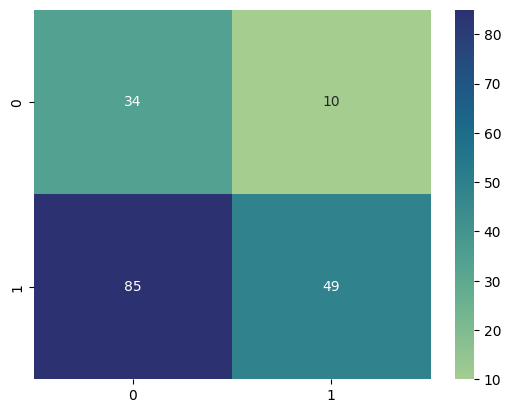

In [ ]:
cm = confusion_matrix(df_pred['Etiqueta Original'],df_pred['Etiqueta predicha'])
sns.heatmap(cm, annot=True, fmt = "d",cmap="crest")
print("Matriz de confusión - data set sin datos sinteticos")
print(classification_report(df_pred['Etiqueta Original'],df_pred['Etiqueta predicha']))

### Uso de modelo Pysentimiento con fine-tunning

#### Entrenamiento del modelo

In [ ]:
trainer_tuned = Trainer(
   model=model,
   args=get_training_args(),
   train_dataset=tokenized_reviews['train'],
   eval_dataset=tokenized_reviews['valid'],
   tokenizer=tokenizer,
   #data_collator=data_collator,
   compute_metrics=compute_metrics
)

In [ ]:
trainer_tuned.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


TrainOutput(global_step=104, training_loss=0.3208524997417743, metrics={'train_runtime': 46.7833, 'train_samples_per_second': 35.44, 'train_steps_per_second': 2.223, 'total_flos': 103664214145500.0, 'train_loss': 0.3208524997417743, 'epoch': 2.0})


#### Evaluemos el modelo con datos que no vio durante el entrenamiento

In [ ]:
#Evaluamos los resusltados
trainer_tuned.evaluate(tokenized_reviews['test'])

{'eval_loss': 0.22862184047698975,
 'eval_accuracy': 0.9157303370786517,
 'eval_runtime': 1.9511,
 'eval_samples_per_second': 91.231,
 'eval_steps_per_second': 6.15,
 'epoch': 2.0}

In [ ]:
pred_tuned=trainer.predict(tokenized_reviews['test'])

In [ ]:
preds_tuned = pred_tuned.predictions.argmax(-1)
labels = pd.Series(preds_tuned).map(model.config.id2label)
scores = (np.exp(pred_tuned[0])/np.exp(pred_tuned[0]).sum(-1,keepdims=True)).max(1)

##### Conversión de datos para visualización en un data frame.

In [ ]:
# Create DataFrame with texts, predictions, labels, and scores
df_pred_tuned = pd.DataFrame(list(zip(train_test_valid_dataset['test']['text'],train_test_valid_dataset['test']['labels'],preds_tuned,scores)), columns=['Opiniones','Etiqueta Original','Etiqueta predicha','score'])
df_pred_tuned.head()

,Opiniones,Etiqueta Original,Etiqueta predicha,score
0,"Excelente atención por parte del personal, las...",1,1,0.987615
1,se disculparon conmigo y me enviaron chocolate...,0,0,0.835108
2,No conocí el hotel antes del cambio de adminis...,1,1,0.973467
3,Muchas felicidades por hacer de mi estadía la ...,1,1,0.986464
4,"te sientes a gusto como en casa, habitaciones ...",1,1,0.784102


##### Evaluación de datos que el modelo predijo con los datos originales con una matriz de confusión.

Matriz de confusión - data set sin datos sintéticos
              precision    recall  f1-score   support

           0       0.85      0.80      0.82        44
           1       0.93      0.96      0.94       134

    accuracy                           0.92       178
   macro avg       0.89      0.88      0.88       178
weighted avg       0.91      0.92      0.91       178



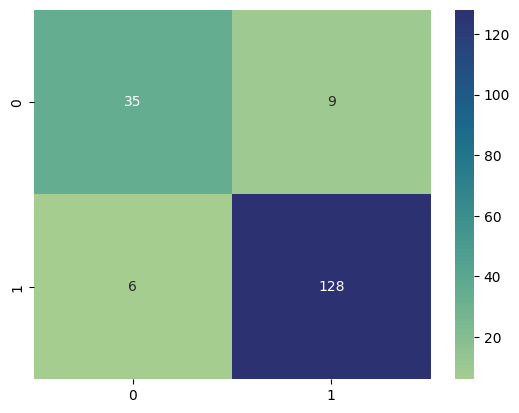

In [ ]:
cm = confusion_matrix(df_pred_tuned['Etiqueta Original'],df_pred_tuned['Etiqueta predicha'])
sns.heatmap(cm, annot=True, fmt = "d",cmap="crest")
print("Matriz de confusión - data set sin datos sintéticos")
print(classification_report(df_pred_tuned['Etiqueta Original'],df_pred_tuned['Etiqueta predicha']))

###6.-Ahora realiza el entrenamiento y evaluación de los conjuntos aumentados (reales más sintéticos). En este caso sí aplica un modelo con fine-tuning. ¿Por qué en este caso no se justificaría utilizar la técnica out-of-box para entrenar y evaluar directamente los datos con los comentarios sintéticos?###

##### Balanceo de los datos de entrenamiento

Los comentarios sintéticos se insertan solamente en el conjunto de entrenamiento para evitar el filtrado de información (data leak).

In [ ]:
balanced_comments = train_test_valid_dataset['train']['text'] + positive_comments + negative_comments
balanced_labels = train_test_valid_dataset['train']['labels'] + positive_labels + negative_labels

In [ ]:
for comment, label in zip(negative_comments, negative_labels):
  train_test_valid_dataset['train'] = train_test_valid_dataset['train'].add_item({'text': comment, 'labels': label})

for comment, label in zip(positive_comments, positive_labels):
  train_test_valid_dataset['train'] = train_test_valid_dataset['train'].add_item({'text': comment, 'labels': label})

In [ ]:
# # Calcula la proporción de etiquetas positivas y negativas

label_count = train_test_valid_dataset['train'].to_pandas().labels.value_counts()
proportion_positive, proportion_negative = (label_count/len(train_test_valid_dataset['train']['labels'])).tolist()
# Imprime la proporción de etiquetas positivas y negativas
print(f"Proporción de etiquetas positivas: {proportion_positive:.2f}")
print(f"Proporción de etiquetas negativas: {proportion_negative:.2f}")

Proporción de etiquetas positivas: 0.57
Proporción de etiquetas negativas: 0.43


**Nota:**

Partiendo de una proporción inicial con 75% /  25%, se balanceó el conjunto de datos de entrenamiento a un 57% / 43%

##### Visualización de las particiones

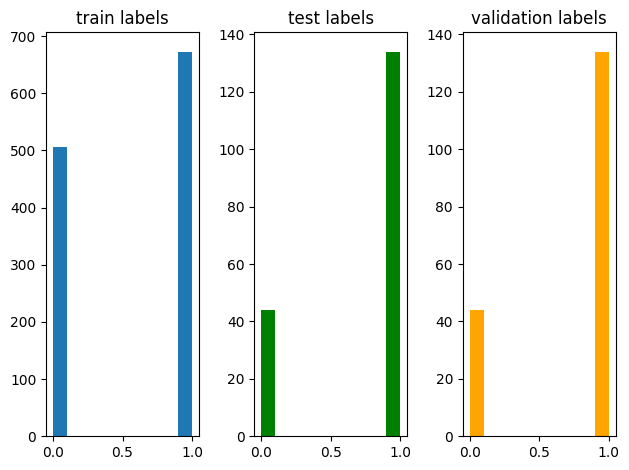

In [ ]:
fig,(ax1, ax2, ax3) = plt.subplots(1,3)
ax1.set_title('train labels')
ax1.hist(train_test_valid_dataset['train']['labels'])
ax2.set_title('test labels')
ax2.hist(train_test_valid_dataset['test']['labels'],color='green')
ax3.set_title('validation labels')
ax3.hist(train_test_valid_dataset['valid']['labels'],color='orange')
fig.tight_layout()

#### Carga del modelo y tokenizacion

In [ ]:
#Obtenemos el modelo
model, tokenizer, collator = get_model('pysentimiento/robertuito-base-uncased', num_labels = 2, max_length = 128)

Some weights of the model checkpoint at pysentimiento/robertuito-base-uncased were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pysentimiento/robertuito-base-uncased and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj

In [ ]:
tokenized_reviews_gen = train_test_valid_dataset.map(
    lambda batch: tokenizer(batch['text'], padding=False, truncation=True),
    batched=True, batch_size=32)

Map:   0%|          | 0/1179 [00:00<?, ? examples/s]

### Uso de modelo Pysentimiento con fine-tunning

#### Entrenamiento del modelo

In [ ]:
trainer_tuned_gen = Trainer(
   model=model,
   args=get_training_args(),
   train_dataset=tokenized_reviews_gen['train'],
   eval_dataset=tokenized_reviews_gen['valid'],
   tokenizer=tokenizer,
   #data_collator=data_collator,
   compute_metrics=compute_metrics
)

In [ ]:
trainer_tuned_gen.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


TrainOutput(global_step=148, training_loss=0.22268661292823586, metrics={'train_runtime': 65.4581, 'train_samples_per_second': 36.023, 'train_steps_per_second': 2.261, 'total_flos': 139011539989020.0, 'train_loss': 0.22268661292823586, 'epoch': 2.0})


#### Evaluemos el modelo con datos que no vio durante el entrenamiento

In [ ]:
#Evaluamos los resusltados
trainer_tuned_gen.evaluate(tokenized_reviews_gen['test'])

{'eval_loss': 0.21927377581596375,
 'eval_accuracy': 0.9213483146067416,
 'eval_runtime': 2.0074,
 'eval_samples_per_second': 88.672,
 'eval_steps_per_second': 5.978,
 'epoch': 2.0}

In [ ]:
pred_tuned_gen=trainer_tuned_gen.predict(tokenized_reviews_gen['test'])

In [ ]:
preds_tuned_gen = pred_tuned_gen.predictions.argmax(-1)
labels = pd.Series(preds_tuned_gen).map(model.config.id2label)
scores = (np.exp(pred_tuned_gen[0])/np.exp(pred_tuned_gen[0]).sum(-1,keepdims=True)).max(1)

##### Conversión de datos para visualización en un data frame.

In [ ]:
# Create DataFrame with texts, predictions, labels, and scores
df_pred_tuned_gen = pd.DataFrame(list(zip(train_test_valid_dataset['test']['text'],train_test_valid_dataset['test']['labels'],preds_tuned_gen,scores)), columns=['Opiniones','Etiqueta Original','Etiqueta predicha','score'])
df_pred_tuned_gen.head()

,Opiniones,Etiqueta Original,Etiqueta predicha,score
0,"Excelente atención por parte del personal, las...",1,1,0.994785
1,se disculparon conmigo y me enviaron chocolate...,0,0,0.955926
2,No conocí el hotel antes del cambio de adminis...,1,1,0.984629
3,Muchas felicidades por hacer de mi estadía la ...,1,1,0.992820
4,"te sientes a gusto como en casa, habitaciones ...",1,1,0.832077


##### Evaluación de datos que el modelo predijo con los datos originales con una matriz de confusión.

Matriz de confusión - data set con datos sinteticos
              precision    recall  f1-score   support

           0       0.86      0.82      0.84        44
           1       0.94      0.96      0.95       134

    accuracy                           0.92       178
   macro avg       0.90      0.89      0.89       178
weighted avg       0.92      0.92      0.92       178



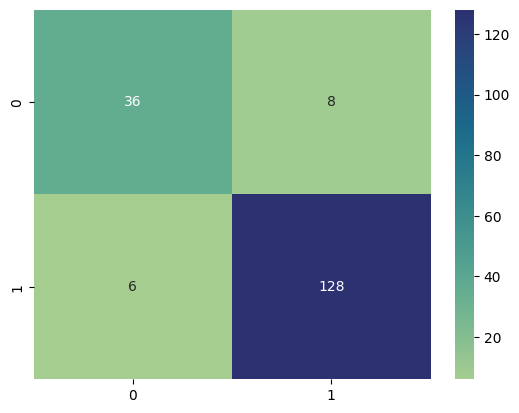

In [ ]:
cm = confusion_matrix(df_pred_tuned_gen['Etiqueta Original'],df_pred_tuned_gen['Etiqueta predicha'])
sns.heatmap(cm, annot=True, fmt = "d",cmap="crest")
print("Matriz de confusión - data set con datos sinteticos")
print(classification_report(df_pred_tuned_gen['Etiqueta Original'],df_pred_tuned_gen['Etiqueta predicha']))

###7.- Compara los resultados e incluye tus comentarios. En particular, indica si consideras que los comentarios sintéticos fueron de ayuda en este caso.###


A continuación se presenta una tabla comparativa con los resultados obtenidos:

| Modelo                              | Exactitud | Precisi'on | Recall |
|-------------------------------------|-----------|------------|--------|
| Out of the box sin datos sinteticos | 47%       | 83%        | 37%    |
| Entrenado sin datos sinteticos      | 92%       | 93%        | 96%    |
| Entrenado con datos sinteticos      | 92%       | 94%        | 96%    |

Tomando en cuenta los resultados de los tres experimentos que realizamos, podemos sacar las siguientes conclusiones:

Experimento 1:
En este experimento, no se utilizaron datos sintéticos y no se aplicaron parámetros de ajuste al modelo. Los resultados muestran una precisión moderadamente alta (0.83) y una precisión baja (0.37), lo que indica que el modelo es capaz de identificar correctamente una buena proporción de muestras positivas, pero tiene dificultades para detectar las muestras negativas. El accuracy general también es bajo (0.47), lo que sugiere que el modelo no tiene un buen rendimiento en general.

Experimento 2:
En este experimento, se utilizaron datos sintéticos para abordar el desbalanceo del dataset y se aplicaron parámetros de ajuste al modelo. Los resultados muestran un aumento significativo en todas las métricas: accuracy (0.92), precisión (0.93) y recall (0.96). Esto indica que la inclusión de datos sintéticos y la optimización de los parámetros del modelo han mejorado en gran medida su rendimiento. El modelo es capaz de clasificar correctamente la mayoría de las muestras y tiene un equilibrio entre la precisión y el recall.

Experimento 3:
En este experimento, se utilizaron datos sintéticos junto con la aplicación de parámetros de ajuste al modelo. Los resultados son similares a los del experimento 2, con altos valores de accuracy (0.92), precisión (0.94) y recall (0.96). Esto indica que el ajuste de los parámetros del modelo ha mejorado aún más su rendimiento, especialmente en términos de precisión.

Si bien los resultados del experimento 3 muestran un rendimiento similar al del experimento 2, es posible que los datos sintéticos no hayan hecho una diferencia significativa en este caso particular. La mejora en las métricas de precisión, recall y accuracy podría estar principalmente impulsada por la aplicación de parámetros de ajuste al modelo.

Es importante tener en cuenta que el impacto de los datos sintéticos puede variar según el conjunto de datos y el modelo utilizado. En algunos casos, los datos sintéticos pueden proporcionar una mayor diversidad y equilibrio a los datos desbalanceados, lo que mejora el rendimiento del modelo. Sin embargo, en otros casos, los datos sintéticos pueden no ser tan efectivos o incluso introducir ruido adicional en el modelo.

Dado que los resultados del experimento 2 y el experimento 3 son similares, es posible que el ajuste de los parámetros del modelo haya sido el factor principal que mejoró el rendimiento. Los parámetros de ajuste pueden influir en la forma en que el modelo aprende de los datos y en cómo se generaliza para clasificar nuevas instancias. En este caso, los parámetros de ajuste parecen haber logrado una mejora significativa en la precisión y recall del modelo.

Como conclusión, aunque los datos sintéticos no hayan tenido un impacto significativo en este experimento específico, el ajuste de los parámetros del modelo resultó ser crucial para mejorar el rendimiento del análisis.


## **Referencias:**

* Devlin, J., Chang, M. W., Lee, K., y Toutanova, K. (2019). BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding. ArXiv, 1810.04805 (1-16). https://arxiv.org/abs/1810.04805

* Falcón Morales, L. E. (2023).  Maestría en Inteligencia Artificial Aplicada. ITESM

* Sudharsan Ravichandiran. (2021).Getting Started with Google BERT. O'Reilly. https://learning.oreilly.com/library/view/getting-started-with/9781838821593/

* S.A. (s.f.). pysentimiento/robertuito-sentiment-analysis, Hugging Face, https://huggingface.co/pysentimiento/robertuito-sentiment-analysis

* S.A.  (s.f.).,siebert/sentiment-roberta-large-english, Hugging Face, https://huggingface.co/siebert/sentiment-roberta-large-english

* S.A., (s.f.). LiYuan/amazon-review-sentiment-analysis, Hugging Face, https://huggingface.co/LiYuan/amazon-review-sentiment-analysis

* S.A., (s.f.). LiYuan/amazon-review-sentiment-analysis, Hugging Face, https://huggingface.co/LiYuan/amazon-review-sentiment-analysis

* S.A., (s.f.).LDistilBERT, Hugging Face, https://huggingface.co/docs/transformers/model_doc/distilbert